### Import

In [1]:
import pandas as pd
import numpy as np
import os
import random

from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
CFG = {
    'NBITS':2048,
    'SEED':42,
}

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(CFG['SEED']) # Seed 고정

### DataLoad

In [10]:
# 학습 ChEMBL 데이터 로드
chembl_data = pd.read_csv('../rdkit_data/rdkit_train_non_category_corr_0.4.csv')  # 예시 파일 이름
chembl_data.head()

,pIC50,MolWt,HeavyAtomMolWt,ExactMolWt,BCUT2D_LOGPLOW,Chi0,Chi0n,Chi0v,Chi1,Chi2n,Kappa1,Kappa3,LabuteASA,SMR_VSA3,SMR_VSA5,SlogP_VSA5
0,10.59,535.624,501.352,535.270716,-2.500926,27.310826,22.307719,22.307719,18.685692,11.341360,25.694355,4.847322,225.948164,24.397878,57.469263,59.389368
1,10.11,537.596,505.340,537.249981,-2.563125,27.310826,22.008861,22.008861,18.685692,10.947914,25.656488,4.834228,224.696767,24.397878,38.206798,40.126903
2,10.09,545.566,515.326,545.236222,-2.476253,27.896612,21.649435,21.649435,18.507059,10.412358,26.879586,5.546010,222.555182,24.397878,38.590402,40.126903
3,10.00,571.604,539.348,571.251873,-2.567951,29.103719,22.856542,22.856542,19.392799,11.674656,27.459394,5.234107,234.279235,24.397878,56.970970,52.968546
4,10.00,473.537,446.321,473.217538,-2.455375,24.156125,19.769469,19.769469,16.970295,9.519913,21.574464,3.511988,201.417234,29.278453,50.105696,54.924759


In [11]:
target = ['pIC50']
x = chembl_data.drop(target, axis = 1)
y = chembl_data.loc[:, target]

# 학습 및 검증 데이터 분리
train_x, val_x, train_y, val_y = train_test_split(x, y, test_size=0.3, random_state=42)

### Train & Validation

In [12]:
# 랜덤 포레스트 모델 학습
model = RandomForestRegressor(random_state=CFG['SEED'])
model.fit(train_x, train_y)

c:\Users\ogong\anaconda3\envs\dacon\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(random_state=42)

In [13]:
def pIC50_to_IC50(pic50_values):
    """Convert pIC50 values to IC50 (nM)."""
    return 10 ** (9 - pic50_values)

# Validation 데이터로부터의 학습 모델 평가
val_y_pred = model.predict(val_x)
mse = mean_squared_error(pIC50_to_IC50(val_y), pIC50_to_IC50(val_y_pred))
rmse = np.sqrt(mse)

print(f'RMSE: {rmse}')

RMSE: 2423.4235188356715


In [14]:
print(model.feature_importances_, '\n')

# 시리즈로 만들어 인덱스를 붙인다
ser = pd.Series(model.feature_importances_, index=x.columns)

# 내림차순 정렬을 이용한다
top = ser.sort_values(ascending=False)[:]
print(top)

[0.01513313 0.03654552 0.01524667 0.1708986  0.07085384 0.02875023
 0.02758467 0.03897395 0.07997365 0.05666506 0.06192873 0.0254475
 0.09997074 0.04903207 0.22299565] 

SlogP_VSA5        0.222996
BCUT2D_LOGPLOW    0.170899
SMR_VSA3          0.099971
Chi2n             0.079974
Chi0              0.070854
Kappa3            0.061929
Kappa1            0.056665
SMR_VSA5          0.049032
Chi1              0.038974
HeavyAtomMolWt    0.036546
Chi0n             0.028750
Chi0v             0.027585
LabuteASA         0.025448
ExactMolWt        0.015247
MolWt             0.015133
dtype: float64


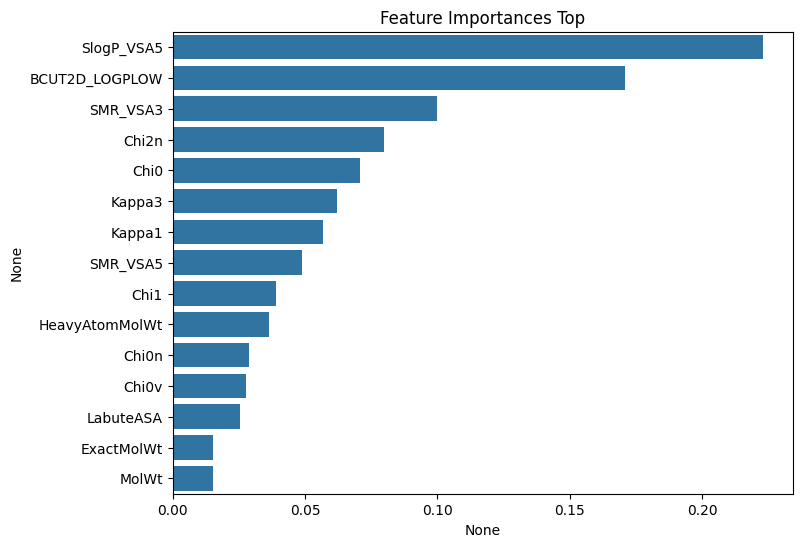

In [15]:
plt.figure(figsize=(8,6))
plt.title('Feature Importances Top')
sns.barplot(x=top, y=top.index)
plt.show()

### Inference

In [19]:
test = pd.read_csv('../rdkit_data/rdkit_test_non_categorycorr_0.4.csv')

test_y_pred = model.predict(test)

### Submission

In [20]:
submit = pd.read_csv('../../../data/sample_submission.csv')
submit['IC50_nM'] = pIC50_to_IC50(test_y_pred)
submit.head()

,ID,IC50_nM
0,TEST_000,14.054002
1,TEST_001,17.200854
2,TEST_002,45.861684
3,TEST_003,9.322878
4,TEST_004,73.428840


In [23]:
submit.to_csv('../../../submit/rdkit/non_categorycorr_0.4_submit.csv', index=False)